https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
lens = train.comment_text.str.len()
lens.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

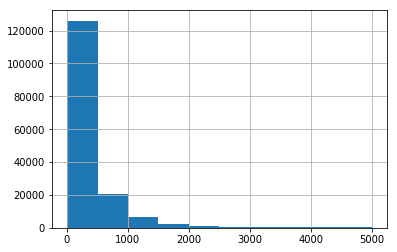

In [5]:
%matplotlib inline
lens.hist()

In [6]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1 - train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
len(train), len(test)

(159571, 153164)

In [8]:
train['comment_text'].fillna('unknown', inplace=True)
train['comment_text'].fillna('unknown', inplace=True)

In [9]:
%%time
import re, string
re_tok = re.compile('([{punc}“”¨«»®´·º½¾¿¡§£₤‘’])'.format(punc=string.punctuation))
def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 403 µs


In [10]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vec = TfidfVectorizer(
    ngram_range=(1, 2), 
    tokenizer=tokenize, 
    min_df=3, 
    max_df=0.9,
    strip_accents='unicode', 
    sublinear_tf=True)

trn_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

CPU times: user 1min 11s, sys: 1.15 s, total: 1min 12s
Wall time: 1min 12s


In [11]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765755 stored elements in Compressed Sparse Row format>)

In [12]:
pd.DataFrame(trn_term_doc.sum(axis=0).T, index=vec.get_feature_names())[0].sort_values(ascending=False)

.                        5313.388414
the                      4114.770000
,                        4088.575353
"                        3887.009831
to                       3396.389798
you                      3359.781848
i                        3347.954071
'                        3163.683995
a                        2900.832193
and                      2765.370096
of                       2735.243427
is                       2639.543843
it                       2550.279734
that                     2400.120196
in                       2193.890963
" "                      2143.378793
for                      2041.348056
?                        2033.166820
this                     2007.686969
:                        1956.591205
not                      1900.295930
)                        1891.956857
-                        1818.759979
on                       1809.202721
be                       1788.136772
(                        1783.890949
!                        1718.315649
s

### Hic sunt dracones

In [23]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p + 1) / ((y == y_i).sum() + 1)

In [24]:
x = trn_term_doc
test_x = test_term_doc

In [25]:
from sklearn.linear_model import LogisticRegression

def get_model(y):
    y = y.values
    r = np.log(pr(1, y) / pr(0, y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [26]:
%%time

preds = np.zeros((len(test), len(label_cols)))

for i, label in enumerate(label_cols):
    print('fit', label)
    m, r = get_model(train[label])
    preds[:, i] = m.predict_proba(test_x.multiply(r))[:, 1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
CPU times: user 1min 45s, sys: 408 ms, total: 1min 46s
Wall time: 1min 46s


In [43]:
submid = pd.DataFrame({'id': sample_submission["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns=label_cols)], axis=1)
submission.head(100)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999988,0.106262,0.999987,0.002369,0.962578,0.094955
1,0000247867823ef7,0.002873,0.000604,0.001893,0.000100,0.002227,0.000342
2,00013b17ad220c46,0.011755,0.000864,0.005588,0.000102,0.003210,0.000297
3,00017563c3f7919a,0.000960,0.000224,0.001141,0.000171,0.001057,0.000297
4,00017695ad8997eb,0.009957,0.000485,0.002009,0.000131,0.002395,0.000351
5,0001ea8717f6de06,0.004428,0.000280,0.001964,0.000373,0.003182,0.000364
6,00024115d4cbde0f,0.000535,0.000156,0.000825,0.000102,0.000704,0.000411
7,000247e83dcc1211,0.187793,0.000366,0.003324,0.000132,0.007759,0.000342
8,00025358d4737918,0.009363,0.000135,0.002518,0.000095,0.003299,0.000394
9,00026d1092fe71cc,0.003037,0.000229,0.002203,0.000110,0.002957,0.000276


In [27]:
SUBMISSION_FILE = 'nb_svm_strong_linear_baseline_submission.csv'
submission.to_csv(SUBMISSION_FILE, index=False)

... and that's it; from now on I'm just randomly playing around

In [19]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999988,0.106262,0.999987,0.002369,0.962578,0.094958
1,0000247867823ef7,0.002873,0.000604,0.001893,0.000100,0.002227,0.000342
2,00013b17ad220c46,0.011755,0.000864,0.005588,0.000102,0.003210,0.000297
3,00017563c3f7919a,0.000960,0.000224,0.001141,0.000171,0.001057,0.000297
4,00017695ad8997eb,0.009957,0.000485,0.002009,0.000131,0.002395,0.000351
5,0001ea8717f6de06,0.004428,0.000280,0.001964,0.000373,0.003182,0.000364
6,00024115d4cbde0f,0.000535,0.000156,0.000825,0.000102,0.000704,0.000411
7,000247e83dcc1211,0.187793,0.000366,0.003324,0.000132,0.007759,0.000342
8,00025358d4737918,0.009363,0.000135,0.002518,0.000095,0.003299,0.000394
9,00026d1092fe71cc,0.003037,0.000229,0.002203,0.000110,0.002957,0.000276


In [40]:
label = 'toxic'

y = train[label].values
y.shape


(159571,)

In [36]:
x

<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
	with 17775104 stored elements in Compressed Sparse Row format>

In [41]:
pr1y = x[y==1].sum(0)
pr1y

matrix([[438.24369931, 296.09499738,  20.7782772 , ...,   0.        ,
           0.        ,   0.        ]])

In [29]:
pr1y = (p + 1) / ((y == 1).sum() + 1)

pr0y = pr(0, y)
np.log(pr1y / pr0y)

matrix([[1.17381793, 2.09428535, 0.21757157, ..., 2.03104827, 0.8448213 ,
         0.8448213 ]])

In [30]:
pr1y

matrix([[2.87181235e-02, 1.94243215e-02, 1.42388213e-03, ...,
         6.53808434e-05, 6.53808434e-05, 6.53808434e-05]])

In [31]:
pr0y

matrix([[8.87919121e-03, 2.39226500e-03, 1.14547050e-03, ...,
         8.57783057e-06, 2.80898416e-05, 2.80898416e-05]])